**IMPORT THE NECESSARY DEPENDENCIES**

In [1]:
import open3d as o3d
import numpy as np
from functools import reduce
from operator import mul
from PIL import Image
import matplotlib.pyplot as plt
import glob
import pytesseract
import os
from os.path import join

import math
import shutil
from moviepy.editor import *
from rlbench.demo import Demo
from rlbench.backend.observation import Observation
from pyrep.objects import VisionSensor
import pickle

import torch
from torch import nn

import trimesh, pyrender
import pyrender
from pyrender.trackball import Trackball
import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2024-07-06 18:12:17,522 - acceleratesupport - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
CAMERAS = ['front']

In [3]:
# Helper functions for reading and displaying pkl files

def read_pickle(filename):
    
    with open(filename, "rb") as myfile:
        observations = pickle.load(myfile)
        
    return observations

def display_pickle(observations):
    for idx, observation in enumerate(observations):
        print(f"Attributes of Observation {idx}:")
        # Printing all attributes of the observation
        for attr, value in observation.__dict__.items():
            print(f"{attr}: {value}")
        print()  # Just for separating each observation

In [4]:
# Helper functions for generating point clouds

def stack_on_channel(x):
    # expect (B, T, C, ...)
    return torch.cat(torch.split(x, 1, dim=1), dim=2).squeeze(1)

def _norm_rgb(x):
    return (x.float() / 255.0) * 2.0 - 1.0

def _preprocess_inputs(replay_sample):
    obs, pcds = [], []
    for n in CAMERAS:
        rgb = stack_on_channel(replay_sample['%s_rgb' % n])
        pcd = stack_on_channel(replay_sample['%s_point_cloud' % n])

        rgb = _norm_rgb(rgb)

        obs.append([rgb, pcd]) # obs contains both rgb and pointcloud (used in ARM for other baselines)
        pcds.append(pcd) # only pointcloud
    return obs, pcds

def _preprocess_inputs_new(rgb, point_cloud):
    obs, pcds = [], []

    rgb = stack_on_channel(rgb)
    pcd = stack_on_channel(point_cloud)

    rgb = _norm_rgb(rgb)

    obs.append([rgb, pcd]) # obs contains both rgb and pointcloud (used in ARM for other baselines)
    pcds.append(pcd) # only pointcloud
    return obs, pcds

In [5]:
scene_bounds_cumulative = []

# **Part 1: look at a subset of images to determine appropriate crop size and rescaling factor**

In [9]:
RAW_SCENE_NAME = "LampOnNew" # name of original data folder (contains raw data from AR2D2 app)
TEST_EPISODE_NUMBER = 1 # choose an episode to determine crop size etc.
SCENE_NAME = "on_lamp_new"
DATA_DIR = f"{RAW_SCENE_NAME}/episode{TEST_EPISODE_NUMBER}"


os.path.exists(DATA_DIR)

depth_paths = glob.glob(f"{DATA_DIR}/depth_*.PNG")
text_paths = glob.glob(f"{DATA_DIR}/text_*.PNG")
rgb_paths = list(set(glob.glob(f"{DATA_DIR}/*.PNG")) - set(depth_paths).union(text_paths))

In [10]:
def sort_paths(paths):
    paths.sort(key = lambda path: int(path.split("_")[-1][:-4]))
    
for paths in [depth_paths, text_paths, rgb_paths]:
    sort_paths(paths)
    
# check if paths are sorted
depth_paths, text_paths, rgb_paths

(['LampOnNew/episode1/depth_240706_18-04-08.1043_512.PNG',
  'LampOnNew/episode1/depth_240706_18-04-08.1043_522.PNG',
  'LampOnNew/episode1/depth_240706_18-04-08.1043_532.PNG',
  'LampOnNew/episode1/depth_240706_18-04-08.1043_542.PNG',
  'LampOnNew/episode1/depth_240706_18-04-08.1043_552.PNG',
  'LampOnNew/episode1/depth_240706_18-04-08.1043_562.PNG',
  'LampOnNew/episode1/depth_240706_18-04-08.1043_572.PNG',
  'LampOnNew/episode1/depth_240706_18-04-08.1043_582.PNG',
  'LampOnNew/episode1/depth_240706_18-04-08.1043_592.PNG',
  'LampOnNew/episode1/depth_240706_18-04-08.1043_602.PNG',
  'LampOnNew/episode1/depth_240706_18-04-08.1043_612.PNG',
  'LampOnNew/episode1/depth_240706_18-04-08.1043_622.PNG',
  'LampOnNew/episode1/depth_240706_18-04-08.1043_632.PNG',
  'LampOnNew/episode1/depth_240706_18-04-08.1043_752.PNG',
  'LampOnNew/episode1/depth_240706_18-04-08.1043_762.PNG',
  'LampOnNew/episode1/depth_240706_18-04-08.1043_772.PNG',
  'LampOnNew/episode1/depth_240706_18-04-08.1043_782.PNG

In [11]:
CAMERA_FAR, CAMERA_NEAR = 5.0, 0.1
DEVICE_CAMERA_WIDTH, DEVICE_CAMERA_HEIGHT = 1668, 2388

In [12]:
# Extract Keypoint Data per frame (from the text files)
frame_info = []
keypoint_indices_test = []


for n, text_path in tqdm.tqdm(enumerate(text_paths)):

    temp = pytesseract.image_to_string(Image.open(text_path)).strip().split()
    temp_list = []

    for i, val in enumerate(temp):
        if val == "-":
            temp[i+1] = "-" + temp[i+1]
        else:
            temp_list.append(float(val))

    kp_frame, kp_screenpos = 0 if n == 0 else temp_list[-4], temp_list[-3:]
    if kp_frame:
        kp_x, kp_y, kp_depth = int(kp_screenpos[0]), \
                            DEVICE_CAMERA_HEIGHT-int(kp_screenpos[1]), \
                            math.ceil((kp_screenpos[2] - 0.08) / CAMERA_FAR * 255)


        kp_x, kp_y = min(kp_x, DEVICE_CAMERA_WIDTH), max(kp_y, 0)


        frame_dict = {
            "kp_x": kp_x,
            "kp_y": kp_y,
            "kp_depth": kp_depth,
        }


        keypoint_indices_test.append(n)
        frame_info.append(frame_dict)
    
NEW_RGB_DIR_TEST = f"{SCENE_NAME}/all_variations/episodes/test/front_rgb_temp/"
NEW_DEPTH_DIR_TEST = f"{SCENE_NAME}/all_variations/episodes/test/front_depth_temp/"

FINAL_RGB_DIR_TEST = f"{SCENE_NAME}/all_variations/episodes/test/front_rgb/"
FINAL_DEPTH_DIR_TEST = f"{SCENE_NAME}/all_variations/episodes/test/front_depth/"

19it [00:05,  3.76it/s]


In [13]:
# new rgb and depth directories (under episode 0)
NEW_RGB_DIR_TEST, NEW_DEPTH_DIR_TEST, FINAL_RGB_DIR_TEST, FINAL_DEPTH_DIR_TEST

('on_lamp_new/all_variations/episodes/test/front_rgb_temp/',
 'on_lamp_new/all_variations/episodes/test/front_depth_temp/',
 'on_lamp_new/all_variations/episodes/test/front_rgb/',
 'on_lamp_new/all_variations/episodes/test/front_depth/')

In [14]:
if os.path.exists(NEW_RGB_DIR_TEST): shutil.rmtree(NEW_RGB_DIR_TEST)
if os.path.exists(NEW_DEPTH_DIR_TEST): shutil.rmtree(NEW_DEPTH_DIR_TEST)
if os.path.exists(FINAL_RGB_DIR_TEST): shutil.rmtree(FINAL_RGB_DIR_TEST)
if os.path.exists(FINAL_DEPTH_DIR_TEST): shutil.rmtree(FINAL_DEPTH_DIR_TEST)
if (not os.path.exists(NEW_RGB_DIR_TEST)): os.makedirs(NEW_RGB_DIR_TEST)
if (not os.path.exists(NEW_DEPTH_DIR_TEST)): os.makedirs(NEW_DEPTH_DIR_TEST)
if (not os.path.exists(FINAL_RGB_DIR_TEST)): os.makedirs(FINAL_RGB_DIR_TEST)
if (not os.path.exists(FINAL_DEPTH_DIR_TEST)): os.makedirs(FINAL_DEPTH_DIR_TEST)

In [15]:
num_kps_so_far = 0
for i, (rgb_path, depth_path) in tqdm.tqdm(enumerate(zip(rgb_paths, depth_paths))):
    
    if i in keypoint_indices_test:
        
        new_rgb_path, new_depth_path = os.path.join(NEW_RGB_DIR_TEST, f"{num_kps_so_far}.png"), \
                                    os.path.join(NEW_DEPTH_DIR_TEST, f"{num_kps_so_far}.png")
        final_rgb_path, final_depth_path = os.path.join(FINAL_RGB_DIR_TEST, f"{num_kps_so_far}.png"), \
                                    os.path.join(FINAL_DEPTH_DIR_TEST, f"{num_kps_so_far}.png")
        
        shutil.copy(depth_path, new_depth_path)
        shutil.copy(rgb_path, new_rgb_path)
        shutil.copy(depth_path, final_depth_path)
        shutil.copy(rgb_path, final_rgb_path)
        Image.fromarray(
            np.array(
                Image.open(new_rgb_path).resize((DEVICE_CAMERA_WIDTH, DEVICE_CAMERA_HEIGHT))
            )[:, :, :3]).save(new_rgb_path)
        Image.fromarray(
            np.array(
                Image.open(new_depth_path).resize((DEVICE_CAMERA_WIDTH, DEVICE_CAMERA_HEIGHT))
            )[:, :, :3]).save(new_depth_path)
        Image.fromarray(
            np.array(
                Image.open(final_rgb_path).resize((DEVICE_CAMERA_WIDTH, DEVICE_CAMERA_HEIGHT))
            )[:, :, :3]).save(final_rgb_path)
        Image.fromarray(
            np.array(
                Image.open(final_depth_path).resize((DEVICE_CAMERA_WIDTH, DEVICE_CAMERA_HEIGHT))
            )[:, :, :3]).save(final_depth_path)
        
        num_kps_so_far += 1
    
    
print(f"{i + 1} frames saved")

19it [00:03,  4.94it/s]

19 frames saved


In [16]:
NEW_RGB_PATHS, NEW_DEPTH_PATHS = os.listdir(NEW_RGB_DIR_TEST), os.listdir(NEW_DEPTH_DIR_TEST)
sort_paths(NEW_RGB_PATHS)
sort_paths(NEW_DEPTH_PATHS)
NEW_RGB_PATHS = list(map(lambda x: os.path.join(NEW_RGB_DIR_TEST, x), NEW_RGB_PATHS))
NEW_DEPTH_PATHS = list(map(lambda x: os.path.join(NEW_DEPTH_DIR_TEST, x), NEW_DEPTH_PATHS))

FINAL_RGB_PATHS, FINAL_DEPTH_PATHS = os.listdir(FINAL_RGB_DIR_TEST), os.listdir(FINAL_DEPTH_DIR_TEST)
sort_paths(FINAL_RGB_PATHS)
sort_paths(FINAL_DEPTH_PATHS)
FINAL_RGB_PATHS = list(map(lambda x: os.path.join(FINAL_RGB_DIR_TEST, x), FINAL_RGB_PATHS))
FINAL_DEPTH_PATHS = list(map(lambda x: os.path.join(FINAL_DEPTH_DIR_TEST, x), FINAL_DEPTH_PATHS))

# check if rgb + depth files have been saved in the right location

NEW_RGB_PATHS, NEW_DEPTH_PATHS, FINAL_RGB_PATHS, FINAL_DEPTH_PATHS

(['on_lamp_new/all_variations/episodes/test/front_rgb_temp/0.png',
  'on_lamp_new/all_variations/episodes/test/front_rgb_temp/1.png'],
 ['on_lamp_new/all_variations/episodes/test/front_depth_temp/0.png',
  'on_lamp_new/all_variations/episodes/test/front_depth_temp/1.png'],
 ['on_lamp_new/all_variations/episodes/test/front_rgb/0.png',
  'on_lamp_new/all_variations/episodes/test/front_rgb/1.png'],
 ['on_lamp_new/all_variations/episodes/test/front_depth/0.png',
  'on_lamp_new/all_variations/episodes/test/front_depth/1.png'])

In [17]:
def get_image_by_idx(idx, type="rgb", as_numpy=True, temp=True):
    rgb_paths_func = []
    depth_paths_func = []
    
    if (temp):
        rgb_paths_func = NEW_RGB_PATHS
        depth_paths_func = NEW_DEPTH_PATHS
    else:
        rgb_paths_func = FINAL_RGB_PATHS
        depth_paths_func = FINAL_DEPTH_PATHS
    
    if type == "rgb":
        return Image.open(rgb_paths_func[idx]) if not as_numpy else np.array(Image.open(rgb_paths_func[idx]))
    else:
        return Image.open(depth_paths_func[idx]) if not as_numpy else np.array(Image.open(depth_paths_func[idx]))

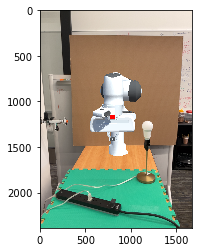

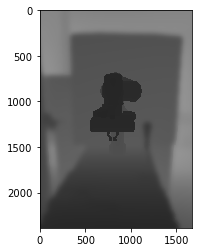

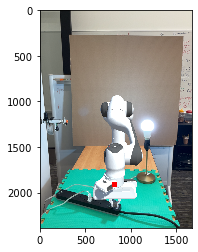

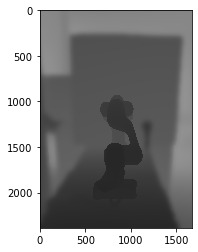

In [18]:
# place keypoint on all images

SHOW_IMAGES = True # optionally display images to see if keypoint placement is correct
for i, (new_rgb_path, new_depth_path, frame_dict) in enumerate(zip(NEW_RGB_PATHS, NEW_DEPTH_PATHS, frame_info)):
    rgb_img, depth_img = get_image_by_idx(i), get_image_by_idx(i, "depth")
    if frame_dict["kp_x"] >= 0 and frame_dict["kp_y"] >= 0:
        rgb_img[
            frame_dict["kp_y"] - 25 : frame_dict["kp_y"] + 25,
            frame_dict["kp_x"] - 25 : frame_dict["kp_x"] + 25,
        ] = [255, 0, 0]
        depth_img[
            frame_dict["kp_y"] - 25 : frame_dict["kp_y"] + 25,
            frame_dict["kp_x"] - 25 : frame_dict["kp_x"] + 25,
        ] = [frame_dict["kp_depth"]] * 3
        Image.fromarray(rgb_img).save(new_rgb_path)
        Image.fromarray(depth_img).save(new_depth_path)
        if SHOW_IMAGES:
            plt.imshow(rgb_img)
            plt.show()
            plt.imshow(depth_img)
            plt.show()

In [19]:
ORIG_WIDTH, ORIG_HEIGHT = DEVICE_CAMERA_WIDTH, DEVICE_CAMERA_HEIGHT
SCALING_FACTOR = 1
TEMP_WIDTH, TEMP_HEIGHT = int(ORIG_WIDTH / SCALING_FACTOR), int(ORIG_HEIGHT / SCALING_FACTOR)
TEMP_WIDTH, TEMP_HEIGHT

(1668, 2388)

In [20]:
SHOW_IMAGES = True

if TEMP_WIDTH != ORIG_WIDTH or TEMP_HEIGHT != ORIG_HEIGHT:
    for i, (new_rgb_path, new_depth_path, final_rgb_path, final_depth_path) in enumerate(zip(
        NEW_RGB_PATHS, NEW_DEPTH_PATHS, FINAL_RGB_PATHS, FINAL_DEPTH_PATHS)):
        rgb_img, depth_img = get_image_by_idx(i), get_image_by_idx(i, "depth")
        final_rgb_img, final_depth_img = get_image_by_idx(i, temp=False), get_image_by_idx(i, "depth", temp=False)
        Image.fromarray(rgb_img).resize((TEMP_WIDTH, TEMP_HEIGHT)).save(new_rgb_path)
        Image.fromarray(depth_img).resize((TEMP_WIDTH, TEMP_HEIGHT)).save(new_depth_path)
        Image.fromarray(final_rgb_img).resize((TEMP_WIDTH, TEMP_HEIGHT)).save(final_rgb_path)
        Image.fromarray(final_depth_img).resize((TEMP_WIDTH, TEMP_HEIGHT)).save(final_depth_path)
        
    for kp_i in range(num_kps_so_far):
        plt.imshow(get_image_by_idx(kp_i, "rgb"))
        plt.show()
        plt.imshow(get_image_by_idx(kp_i, "depth"))
        plt.show()

In [21]:
START_W, START_H = 20, 0
END_W, END_H = 1520, 2388

def decide_crop(sw = START_W, sh = START_H, ew = END_W, eh = END_H):
    for kp_i in range(num_kps_so_far):
        rgb_array = get_image_by_idx(kp_i, "rgb")
        depth_array = get_image_by_idx(kp_i, "depth")
        rgb_cropped_array = rgb_array[sh:eh, sw:ew]
        depth_cropped_array = depth_array[sh:eh, sw:ew]
        
        plt.imshow(rgb_cropped_array)
        plt.show()
        plt.imshow(depth_cropped_array)
        plt.show()
    
    return sw,sh,ew,eh

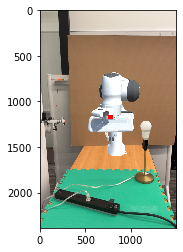

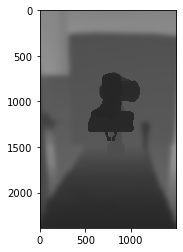

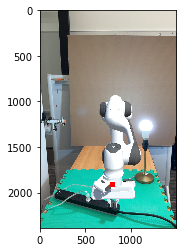

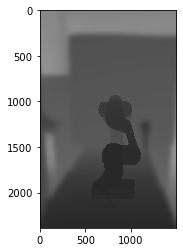

(20, 0, 1520, 2388)

In [22]:
decide_crop()

In [23]:
# update camera intrinsics to account for crop + resizing
INTRINSIC = [
    [1600, 0, 951.6],
    [0, 1600, 710.6,],
    [0, 0, 1]
]

intrinsic = np.array(INTRINSIC)

intrinsic[0][0] /= SCALING_FACTOR
intrinsic[1][1] /= SCALING_FACTOR
intrinsic[0][2] /= SCALING_FACTOR
intrinsic[1][2] /= SCALING_FACTOR
intrinsic[0][2] -= START_W
intrinsic[1][2] -= START_H

EXTRINSICS = np.array([[-0.02077168,  0.26608292, -0.96372632,  1.34098401],
                      [0.99945021,  0.03044192, -0.0131367 ,  0.07254719],
                      [0.02584223, -0.96346934, -0.26656896,  0.68039529],
                      [0.        ,  0.        ,  0.        ,  1.]])

In [24]:
# Fix the rotation of the end effector, so that it points downwards
FIXED_QUAT = [-9.99999648e-01, -3.30362557e-04,  6.10757140e-04,  4.70460149e-04]
FIXED_ROT_MATRIX = np.array([[ 9.99999036e-01,  6.60150207e-04, -1.22182469e-03],
                    [ 6.61299555e-04, -9.99999339e-01,  9.40516425e-04],
                    [-1.22120300e-03, -9.41323510e-04, -9.99998811e-01]])

In [25]:
FINAL_WIDTH, FINAL_HEIGHT = get_image_by_idx(0).shape[:2][::-1]
NUM_EPISODES = len(os.listdir(RAW_SCENE_NAME))
FINAL_WIDTH, FINAL_HEIGHT, NUM_EPISODES

(1668, 2388, 1)

# **Part 2: Generating training data (includes depth maps, rgb images, and a low dimensional pkl object file) for each episode**

In [26]:
DESCRIPTION = "Turn the lamp on"

for EPISODE_NUMBER in tqdm.tqdm(range(1, NUM_EPISODES + 1)):
    DATA_DIR = f"{RAW_SCENE_NAME}/episode{EPISODE_NUMBER}"
    depth_paths = glob.glob(f"{DATA_DIR}/depth_*.PNG")
    text_paths = glob.glob(f"{DATA_DIR}/text_*.PNG")
    rgb_paths = list(set(glob.glob(f"{DATA_DIR}/*.PNG")) - set(depth_paths).union(text_paths))
    
    for paths in [depth_paths, text_paths, rgb_paths]:
        sort_paths(paths)

    FINAL_RGB_DIR = f"{SCENE_NAME}/all_variations/episodes/episode{EPISODE_NUMBER - 1}/front_rgb/"
    FINAL_DEPTH_DIR = f"{SCENE_NAME}/all_variations/episodes/episode{EPISODE_NUMBER - 1}/front_depth/"
    
    if os.path.exists(FINAL_RGB_DIR): shutil.rmtree(FINAL_RGB_DIR)
    if os.path.exists(FINAL_DEPTH_DIR): shutil.rmtree(FINAL_DEPTH_DIR)

    if (not os.path.exists(FINAL_RGB_DIR)): os.makedirs(FINAL_RGB_DIR)
    if (not os.path.exists(FINAL_DEPTH_DIR)): os.makedirs(FINAL_DEPTH_DIR)
        
    for i, (rgb_path, depth_path) in enumerate(zip(rgb_paths, depth_paths)):
        final_rgb_path, final_depth_path = os.path.join(FINAL_RGB_DIR, f"{i}.png"), \
                                        os.path.join(FINAL_DEPTH_DIR, f"{i}.png")
        shutil.copy(depth_path, final_depth_path)
        shutil.copy(rgb_path, final_rgb_path)
        Image.fromarray(
            np.array(
                Image.open(final_rgb_path).resize((DEVICE_CAMERA_WIDTH, DEVICE_CAMERA_HEIGHT))
            )[:, :, :3]).save(final_rgb_path)
        Image.fromarray(
            np.array(
                Image.open(final_depth_path).resize((DEVICE_CAMERA_WIDTH, DEVICE_CAMERA_HEIGHT))
            )[:, :, :3]).save(final_depth_path)
    
    FINAL_RGB_PATHS, FINAL_DEPTH_PATHS = os.listdir(FINAL_RGB_DIR), os.listdir(FINAL_DEPTH_DIR)
    sort_paths(FINAL_RGB_PATHS)
    sort_paths(FINAL_DEPTH_PATHS)
    FINAL_RGB_PATHS = list(map(lambda x: os.path.join(FINAL_RGB_DIR, x), FINAL_RGB_PATHS))
    FINAL_DEPTH_PATHS = list(map(lambda x: os.path.join(FINAL_DEPTH_DIR, x), FINAL_DEPTH_PATHS))
    
    frame_info = []
    keypoint_indices = []


    for n, text_path in enumerate(text_paths):

        temp = pytesseract.image_to_string(Image.open(text_path)).strip().split()
        temp_list = []

        for i, val in enumerate(temp):
            if val == "-":
                temp[i+1] = "-" + temp[i+1]
            else:
                temp_list.append(float(val))

        gripper_open, kp_frame, kp_screenpos = temp_list[-5], 0 if n == 0 else temp_list[-4], temp_list[-3:]
        kp_x, kp_y, kp_depth = int(kp_screenpos[0]), \
                            DEVICE_CAMERA_HEIGHT-int(kp_screenpos[1]), \
                            math.ceil((kp_screenpos[2] - 0.08) / CAMERA_FAR * 255)


        kp_x, kp_y = min(kp_x, DEVICE_CAMERA_WIDTH), max(kp_y, 0)

        frame_dict = {
            "kp_rot": FIXED_QUAT,
            "gripper_open": gripper_open,
            "kp_frame": kp_frame,
            "kp_x": kp_x,
            "kp_y": kp_y,
            "kp_depth": kp_depth,
            "rot_matrix": FIXED_ROT_MATRIX
        }

        if kp_frame:
            keypoint_indices.append(n)
        frame_info.append(frame_dict)
        
    TEMP_WIDTH, TEMP_HEIGHT = int(ORIG_WIDTH / SCALING_FACTOR), int(ORIG_HEIGHT / SCALING_FACTOR)

    if TEMP_WIDTH != ORIG_WIDTH or TEMP_HEIGHT != ORIG_HEIGHT:
        for i, (new_rgb_path, new_depth_path, final_rgb_path, final_depth_path) \
            in enumerate(zip(FINAL_RGB_PATHS, FINAL_DEPTH_PATHS)):
            final_rgb_img, final_depth_img = get_image_by_idx(i, temp=False), get_image_by_idx(i, "depth", temp=False)
            Image.fromarray(final_rgb_img).resize((TEMP_WIDTH, TEMP_HEIGHT)).save(final_rgb_path)
            Image.fromarray(final_depth_img).resize((TEMP_WIDTH, TEMP_HEIGHT)).save(final_depth_path)

        
    for i, (final_rgb_path, final_depth_path, frame_dict) \
        in enumerate(zip(FINAL_RGB_PATHS, FINAL_DEPTH_PATHS, frame_info)):
        rgb_array = get_image_by_idx(i, "rgb", temp=False)
        depth_array = get_image_by_idx(i, "depth", temp=False)
        rgb_cropped_array = rgb_array[START_H:END_H, START_W:END_W]
        depth_cropped_array = depth_array[START_H:END_H, START_W:END_W]

        Image.fromarray(rgb_cropped_array).save(final_rgb_path)
        Image.fromarray(depth_cropped_array).save(final_depth_path)
        
    keypoint_2d_coordinates = []

    for f_dict in frame_info:
        keypoint_coord = np.array([f_dict["kp_x"], f_dict["kp_y"]], dtype = np.float64)
        if (keypoint_coord[0] != -1):
            keypoint_coord /= float(SCALING_FACTOR)
            keypoint_coord[0] -= START_W
            keypoint_coord[1] -= START_H
            if (keypoint_coord[0] < 0 or keypoint_coord[1] < 0 
                or keypoint_coord[0] >= FINAL_WIDTH or 
                keypoint_coord[1] >= FINAL_HEIGHT):
                keypoint_coord = np.array([-1, -1])
        keypoint_coord = keypoint_coord.astype(np.int64)
        keypoint_2d_coordinates.append(keypoint_coord)


    for i, kp in enumerate(keypoint_2d_coordinates):

        if (kp[0] == -1):
            if i != 0:
                keypoint_2d_coordinates[i] = keypoint_2d_coordinates[i-1]
            else:
                keypoint_2d_coordinates[i] = np.array([0, 0])
                
    # get voxel grid for each frame
    pcds = []

    ITERATE_OVER_ALL_FRAMES = True

    trans_points = []

    frame_indices = range(len(FINAL_RGB_PATHS)) if ITERATE_OVER_ALL_FRAMES \
                    else keypoint_indices

    rotation_x= 0 #@param {type:"slider", min:-360, max:360, step:5}
    rotation_y= 0 #@param {type:"slider", min:-360, max:360, step:5}
    rotation_z= 0

    for kp_i in frame_indices:
        depth_img = get_image_by_idx(kp_i, "depth", temp=False)

        float_array = np.sum(depth_img * [65536, 256, 1], axis=2) /  16777215

        float_array = CAMERA_NEAR + float_array * (CAMERA_FAR - CAMERA_NEAR)

        pointcloud = VisionSensor.pointcloud_from_depth_and_camera_params(
                            float_array,
                            EXTRINSICS,
                            intrinsic)


        pcd_flat = pointcloud.reshape((-1,3))

        scene_bounds_min = [pcd_flat[:, i].min() for i in range(3)]
        scene_bounds_max = [pcd_flat[:, i].max() for i in range(3)]
        scene_bounds = scene_bounds_min + scene_bounds_max

        scene_bounds_cumulative.append(scene_bounds)

        kp_coord = keypoint_2d_coordinates[kp_i]
        trans_points.append(pointcloud[kp_coord[1], kp_coord[0]])
        
    for i, frame_info_single in enumerate(frame_info):
        if i <= keypoint_indices[0]:
            frame_info_single["gripper_open"] = 0
            
    observations = []

    for n, (frame_info_single, trans_point) in enumerate(zip(frame_info, trans_points)):

        gripper_pos = np.array(list(trans_point) + FIXED_QUAT)

        rot_matrix = FIXED_ROT_MATRIX
        gripper_matrix = np.zeros((4,4))
        gripper_matrix[:3, :3] = rot_matrix
        gripper_matrix[:3, 3] = trans_point
        gripper_matrix[3, :] = [0, 0, 0, 1]

        obs = Observation(
               left_shoulder_rgb=None,
               left_shoulder_depth=None,
               left_shoulder_point_cloud=None,
               right_shoulder_rgb=None,
               right_shoulder_depth=None,
               right_shoulder_point_cloud=None,
               overhead_rgb=None,
               overhead_depth=None,
               overhead_point_cloud=None,
               wrist_rgb=None,
               wrist_depth=None,
               wrist_point_cloud=None,
               front_rgb=None,
               front_depth=None,
               front_point_cloud=None,
               left_shoulder_mask=None,
               right_shoulder_mask=None,
               overhead_mask=None,
               wrist_mask=None,
               front_mask=None,
               joint_velocities=None,
               joint_positions=None,
               joint_forces=None,
               gripper_open=frame_info_single["gripper_open"],
               gripper_pose=gripper_pos,
               gripper_matrix=gripper_matrix,
               gripper_touch_forces=None,
               gripper_joint_positions=np.array([0.0399342, 0.0399342]),
               task_low_dim_state=None,
               ignore_collisions=True,
               misc={
                   "front_camera_intrinsics": intrinsic,
                   "front_camera_extrinsics": EXTRINSICS,
                   "front_camera_near": CAMERA_NEAR,
                   "front_camera_far": CAMERA_FAR
               },
           )

        observations.append(obs)

    for obs in observations:
        obs.misc["keypoint_idxs"] = np.array(keypoint_indices)

    demo = Demo(observations, random_seed=0)
    
    PICKLED_FILE_NAME = f"{SCENE_NAME}/all_variations/episodes/episode{EPISODE_NUMBER - 1}/low_dim_obs.pkl"
    with open(PICKLED_FILE_NAME, "wb") as file:
        pickle.dump(demo, file)
        
    DESCRIPTION_FILE_NAME = f"{SCENE_NAME}/all_variations/episodes/episode{EPISODE_NUMBER - 1}/variation_descriptions.pkl"

    with open(DESCRIPTION_FILE_NAME, "wb") as file:
        pickle.dump([DESCRIPTION], file)

    

100%|███████████████████████████████████████████████████████████████| 1/1 [00:45<00:00, 45.21s/it]
